In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In this notebook, we will explore a dataset of tweets related to disasters and set up a binary classification model that predicts whether a tweet is referring to a disaster or not. We will follow three main steps to process this data:

* Firstly, we will preprocess the data using various text cleaning techniques to improve the quality of the data. This step will include removing noise, special characters, and stop words.

* Secondly, we will perform exploratory data analysis to understand the distribution of the classes, the length of the tweets, and other important features. This step will help us identify trends and patterns in the data.

* Finally, we will build a text classification model using both a base classification model (Naive Bayes) and a Deep Learning model based on TensorFlow. We will also use a pre-trained model (universal-sentence-encoder) to compare the performance of our base model to the performance of a more complex model.

* We will see that the pre-trained model outperforms the base model (Naive Bayes), achieving an accuracy score of 81.7%.

In [6]:
# Importations des librairies
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import tensorflow_hub as hub

In [7]:
import spacy #load spacy for preprocessing data
nlp = spacy.load("en_core_web_sm")

In [8]:
df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print(df.shape)
df.info()

(7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
df.isna().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [11]:
# This feature will be removed as it is already present in our tweets
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [12]:
#shuffling the rows of the DataFrame
df=df.sample(frac=1,random_state=42)
df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


## 1) Preprocessing text

In [13]:
def preprocessing(sentence):
    sentence = BeautifulSoup(sentence, "lxml").get_text()
    sentence = sentence.lower()
    # Suppression des liens
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = re.sub(r'@\w+', '', sentence)
    #sentence =re.sub( r"(?:\@|https?\://|www)\S+|\#\S+|\$\w+|\&\w+;",'',sentence)
    token = []
    token = [tok.text for tok in nlp(sentence) if not (tok.is_stop or tok.like_num or tok.is_punct or tok.is_space or len(tok) == 1)]
    token = ' '.join([el for el in token])
  
    return token

In [14]:
#Call the tqdm function with the pandas method to enable progress bar for pandas operations
from tqdm import tqdm
tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(preprocessing)

  0%|          | 0/7613 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 7613/7613 [01:18<00:00, 97.36it/s] 


In [15]:
df.head()

,id,keyword,location,text,target,clean_text
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,new weapon cause un imaginable destruction
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,f$ things gishwhes got soaked deluge going pad...
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,dt rt ûïthe col police catch pickpocket liver...
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,aftershock school kick great want thank making...
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,response trauma children addicts develop defen...


# 2 Visualisation des Tweets

<AxesSubplot:>

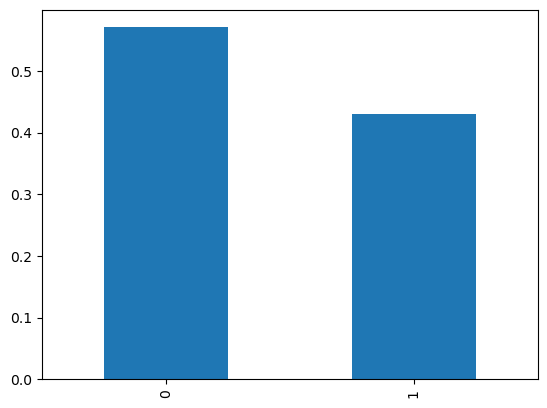

In [16]:
# To check the frequency of each class in the target variable, not Umbalanced Data
df.target.value_counts(normalize=True).plot(kind='bar')

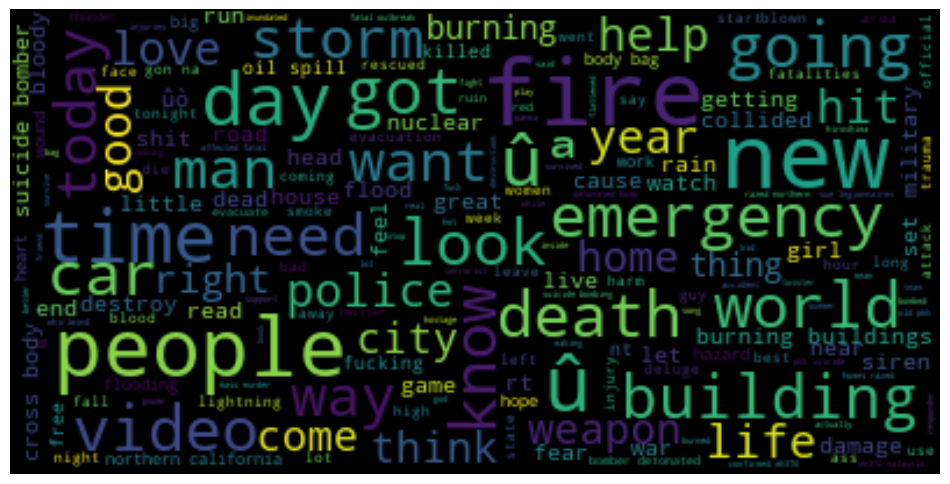

In [17]:
# plotting all the tweet
wordcloud=WordCloud(max_font_size=40).generate("".join(word for word in df.clean_text))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

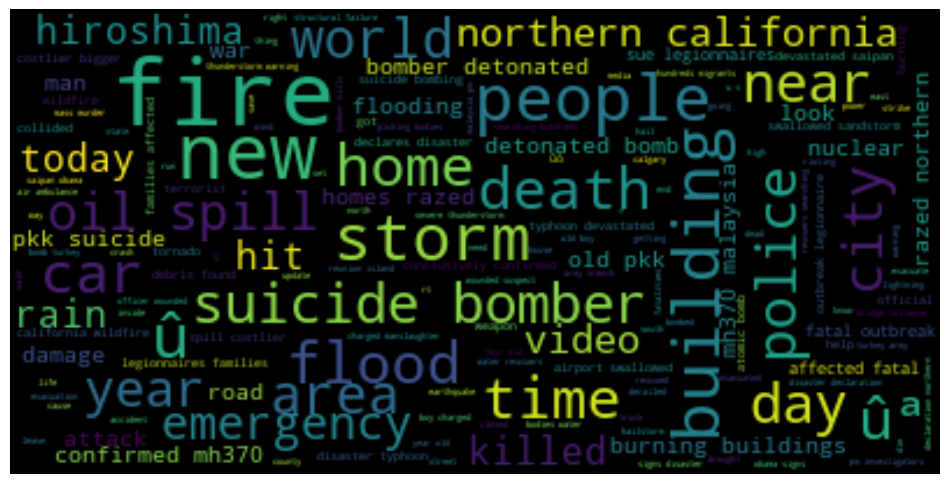

In [18]:
# plotting desaster tweet
desaster_tweet=df[df.target==1].clean_text
wordcloud=WordCloud(max_font_size=40).generate("".join(word for word in desaster_tweet))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

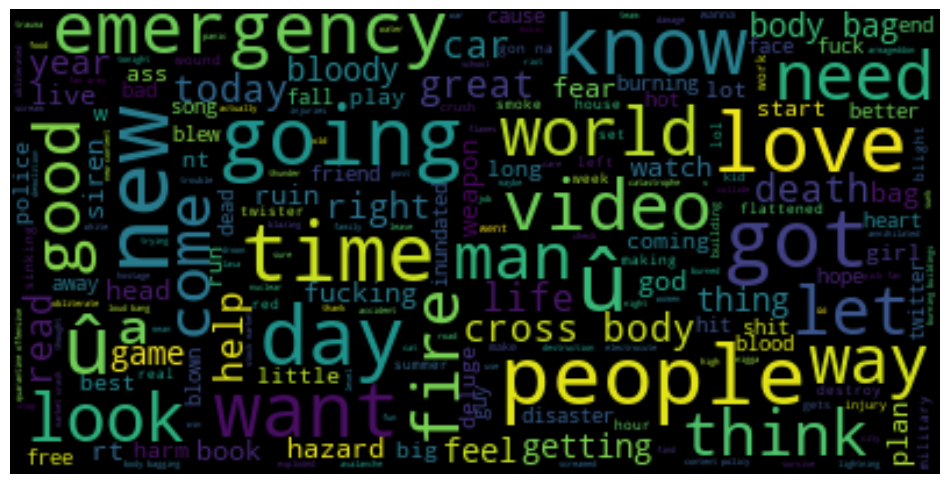

In [19]:
# plotting no desaster tweet
desaster_tweet=df[df.target==0].clean_text
wordcloud=WordCloud(max_font_size=40).generate("".join(word for word in desaster_tweet))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3) Constructing Models

## 3.1) Multinomial Naive Bayes classifier

In [20]:
# set target and features as np array
X=df.clean_text.values
y=df.target.values

In [21]:
# splitting in training and testing dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
# Define the pipeline steps as a list of tuples, where each tuple contains a name and a scikit-learn object
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # convert text data into a numerical representation using TF-IDF scores
    ('naive_model', MultinomialNB())  # train a Multinomial Naive Bayes classifier on the numerical data
])

In [23]:
pipeline.fit(X_train,y_train)
print(pipeline.score(X_test,y_test))

0.7977675640183848


In [24]:
# Classifcation_report
print(classification_report(y_test,pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       858
           1       0.83      0.67      0.74       665

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



## 3.2) Neural Network Models

In [25]:
clean_text_lis=df['clean_text'].to_list() #creates a list of all the cleaned text data in DataFrame.
sent_lengths=[len(sent.split()) for sent in clean_text_lis] #length of each sentence in the list created in the previous step by splitting each sentence into words
mean_len = np.mean(sent_lengths) # mean of our sent
std_len = np.std(sent_lengths) # std of our sent
max_len = int(mean_len + 2 * std_len) # max_len to be equal to the mean plus two times the standard deviation,
max_len

14

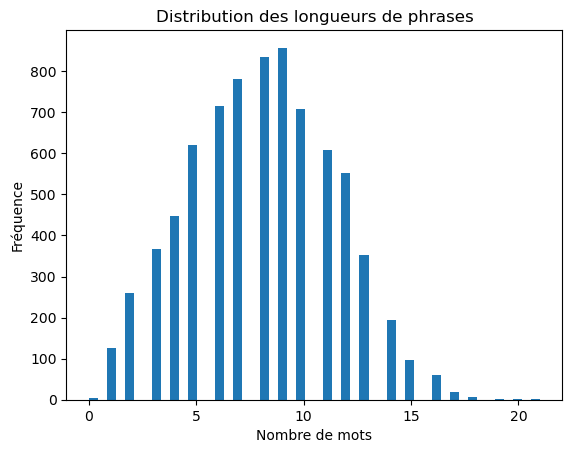

In [26]:
## Visualisation of the sentence
import matplotlib.pyplot as plt

clean_text_lis = df['clean_text'].to_list()
sent_lengths = [len(sent.split()) for sent in clean_text_lis]

plt.hist(sent_lengths, bins=50)
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs de phrases')
plt.show()

In [27]:
# define the vocab size by using countvectprizer
from sklearn.feature_extraction.text import CountVectorizer

# Créez une instance de CountVectorizer
count_vect = CountVectorizer()

# Adapter le vecteur à vos données
count_vect.fit(df['clean_text'])

# Trouver la taille du vocabulaire
vocab_size = len(count_vect.vocabulary_)

print("La taille du vocabulaire est :", vocab_size)

La taille du vocabulaire est : 14266


In [28]:
# TextVectorization layer for converting text data to integers. It takes the following parameters
#max_tokens: maximum size of the vocabulary to be used, which is set to 10,000 in this case but not 14 266 (Hypermat).
#output_mode: the output of the layer, which is set to "int" to output integer sequences.
#output_sequence_length: the length of the output sequences to be generated, which is set to max_len

vectorize_layer=TextVectorization( max_tokens=10000,
 output_mode='int',
 output_sequence_length=max_len)

In [29]:
#creates a TensorFlow Dataset from the cleaned text data in the 'clean_text' column of the DataFrame
text_data=tf.data.Dataset.from_tensor_slices([df.clean_text])

In [30]:
#  fit the layer to the text data and build the vocabulary
vectorize_layer.adapt(text_data)

In [31]:
# prints out the first 10 words in the vocabulary learned by the TextVectorization layer
print(vectorize_layer.get_vocabulary()[:10])

['', '[UNK]', 'like', 'fire', 'new', 'people', 'news', 'video', 'emergency', 'disaster']


In [32]:
# set th embedding layers
embedding=Embedding(input_dim=10000,output_dim=64)

## 3.2.1 Model1> Bidirection --LSTM

In [33]:
tf.random.set_seed(42)
np.random.seed(42)
inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string) # we have one dimension
x=vectorize_layer(inputs)
x=embedding(x)

x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64))(x)
x = tf.expand_dims(x, axis=1) # add extra dimension to tensor for pooling layer (to have the good shape)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
print(x.shape)

outputs=tf.keras.layers.Dense(units=1,activation='sigmoid')(x)

model=tf.keras.Model(inputs,outputs)

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

(None, 128)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 14)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 14, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 128)           0         
                                                                 
 global_average_pooling1d (G  (None, 128)        

In [34]:
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),batch_size=32)

Epoch 1/5
191/191 [==============================] - 10s 26ms/step - loss: 0.5251 - accuracy: 0.7307 - val_loss: 0.4529 - val_accuracy: 0.7997
Epoch 2/5
191/191 [==============================] - 4s 20ms/step - loss: 0.2989 - accuracy: 0.8800 - val_loss: 0.4838 - val_accuracy: 0.7859
Epoch 3/5
191/191 [==============================] - 4s 20ms/step - loss: 0.1942 - accuracy: 0.9332 - val_loss: 0.6218 - val_accuracy: 0.7741
Epoch 4/5
191/191 [==============================] - 4s 20ms/step - loss: 0.1440 - accuracy: 0.9529 - val_loss: 0.5694 - val_accuracy: 0.7708
Epoch 5/5
191/191 [==============================] - 4s 19ms/step - loss: 0.1113 - accuracy: 0.9622 - val_loss: 0.7177 - val_accuracy: 0.7722


In [35]:
model.evaluate(X_test,y_test)
# he Naives Model is better

48/48 [==============================] - 0s 6ms/step - loss: 0.7177 - accuracy: 0.7722


[0.7176842093467712, 0.7721602320671082]

In [36]:
print(classification_report(y_test,model.predict(X_test)>0.5))

48/48 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       858
           1       0.77      0.68      0.72       665

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



## 3.2.2) Pretrained Model

In [37]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],dtype=tf.string,
                                       name='USE',trainable=False)

In [48]:
tf.random.set_seed(42) # set the randon of model
np.random.seed(42)
model2 = tf.keras.Sequential()
model2.add(sentence_encoder_layer)
model2.add(tf.keras.layers.Dense(128,activation='relu'))
model2.add(tf.keras.layers.Dense(64,activation='relu'))
#model2.add(tf.keras.layers.Reshape((-1, 32)))
#model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,activation='tanh')))
model2.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
# training
tf.random.set_seed(42)
np.random.seed(42)
history_pretainad=model2.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
191/191 [==============================] - 4s 14ms/step - loss: 0.4845 - accuracy: 0.7696 - val_loss: 0.4479 - val_accuracy: 0.8037
Epoch 2/5
191/191 [==============================] - 2s 11ms/step - loss: 0.4048 - accuracy: 0.8164 - val_loss: 0.4375 - val_accuracy: 0.8037
Epoch 3/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3784 - accuracy: 0.8373 - val_loss: 0.4395 - val_accuracy: 0.8089
Epoch 4/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3390 - accuracy: 0.8545 - val_loss: 0.4424 - val_accuracy: 0.8050
Epoch 5/5
191/191 [==============================] - 2s 12ms/step - loss: 0.2981 - accuracy: 0.8788 - val_loss: 0.4561 - val_accuracy: 0.8142


In [51]:
model2.evaluate(X_test,y_test)

48/48 [==============================] - 0s 8ms/step - loss: 0.4561 - accuracy: 0.8142


[0.4561040699481964, 0.8141825199127197]

# 4. Predicting on the test data

In [52]:
test_data=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [53]:
test_data['clean_text'] = test_data.text.progress_apply(preprocessing)

  0%|          | 13/3263 [00:00<00:26, 124.65it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 3263/3263 [00:32<00:00, 101.16it/s]


In [54]:
test_data.head(10)

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,shaking earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...,probably life arsenal yesterday eh eh
7,22,NaN,NaN,Hey! How are you?,hey
8,27,NaN,NaN,What a nice hat?,nice hat
9,29,NaN,NaN,Fuck off!,fuck


In [55]:
pred=(model2.predict(test_data['clean_text'])>0.5).astype('int')
pred[:10]

102/102 [==============================] - 1s 8ms/step


array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [56]:
soumission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
soumission.target=pred
soumission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [57]:
soumission.to_csv("ma_soumission.csv",index=False)